# Data Cleansing and Engineering

To handle this task, first thing we have to do is to  build pipelines that transform and transport data into a format that is usable for data analysis.
There are some problem in the dataset that have to be tackle:

- Values in CSV seperated by semicolons, instead of comma.
- Lines that will throw errors when importing with Pandas. (More fields than expected)

These errors are being handled when importing the data.

In [27]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

def read_csv(file):
    df = pd.read_csv(file, sep=';', encoding="latin-1", error_bad_lines=False, warn_bad_lines=False, low_memory=False)
    return df

books = read_csv("BX-Books.csv")
users = read_csv("BX-Users.csv")
ratings = read_csv("BX-Book-Ratings.csv")

Below block will make the header to have a more readable format.

The first few lines are shown for each csv file.

In [2]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]
books.rename(columns = {'Book-Title':'title', 'Book-Author':'author', 'Year-Of-Publication':'year', 'Publisher':'publisher'}, inplace=True)
users.rename(columns = {'User-ID':'user_id', 'Location':'location', 'Age':'age'}, inplace=True)
ratings.rename(columns = {'User-ID':'user_id', 'Book-Rating':'rating'}, inplace=True)

In [3]:
books.head()

,ISBN,title,author,year,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [4]:
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
ratings.head()

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# Data Pre-processing

To make our findings more valuable and insightful, we need to reduce the size of the dataframe. The reason for this is that the dataset contains info which is not valuable to our analysis, for example:

- Users registered but did not make reviews
- Users with only few reviews
- Books that reviewed by limited users

In this case, we will set the threshold to be 50. Only books with more than 50 reviews and users who has made more than 50 reviews will be kept in the dataset.


    

In [6]:
thres = 50

def pre_process(thres, col, df):
    reviewc = df[col].value_counts()
    new_df = df[df[col].isin(reviewc[reviewc >= thres].index)]
    new_df = new_df.reset_index(drop=True)
    return new_df

ratings = pre_process(thres, 'user_id', ratings)
ratings = pre_process(thres, 'ISBN', ratings)
ratings

,user_id,ISBN,rating
0,276847,0446364193,0
1,276925,002542730X,10
2,276925,0316666343,0
3,276925,0385504209,8
4,276925,0804106304,0
...,...,...,...
102015,276688,0553569155,0
102016,276688,0553575090,7
102017,276688,0553575104,6
102018,276688,0679751521,0


After this we will merge the ratings dataset with books, so we can find the ratings of each books from the combined datset.
There are rows with NaN values, in this case we will drop them for informative prediction. 


In [7]:
rating_books = ratings.merge(books, how='left', on='ISBN')
rating_books = rating_books[rating_books['title'].notna()]
rating_books_users = rating_books.merge(users, how='left', on='user_id')
rating_books_users = rating_books_users[rating_books_users['age'].notna()]
rating_books_users = rating_books_users.reset_index(drop=True)

In [8]:
rating_books_users

,user_id,ISBN,rating,title,author,year,publisher,location,age
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,"köln, nordrhein-westfalen, germany",27.0
1,276925,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,"barcelona, barcelona, spain",22.0
2,276925,0316666343,0,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown","barcelona, barcelona, spain",22.0
3,276925,0385504209,8,The Da Vinci Code,Dan Brown,2003,Doubleday,"barcelona, barcelona, spain",22.0
4,276925,0804106304,0,The Joy Luck Club,Amy Tan,1994,Prentice Hall (K-12),"barcelona, barcelona, spain",22.0
...,...,...,...,...,...,...,...,...,...
78024,276680,0446670251,0,The Virgin Suicides,Jeffrey Eugenides,1994,Warner Books,"hopewell junction, new york, usa",55.0
78025,276680,0452283205,7,Falling Angels,Tracy Chevalier,2002,Plume Books,"hopewell junction, new york, usa",55.0
78026,276680,0670030643,0,The Eyre Affair (Alex Awards (Awards)),Jasper Fforde,2002,Viking Books,"hopewell junction, new york, usa",55.0
78027,276680,0679731725,0,The Remains of the Day (Vintage International),Kazuo Ishiguro,1993,Vintage Books USA,"hopewell junction, new york, usa",55.0


# Modelling

Here we will implement Unsupervised Nearest Neighbors as the classificaiton algorithm. The main advantage of this is that it can be used for multiclass classification. Therefore if the data consists of more than two labels, Unsupervised Nearest Neighbors will be a suitable method.

The steps for implementing is listed below:
1. Convert our table to a 2-D matrix.
2. Fill the missing values with zeros
3. Transform the matrix dataframe into a scipy sparse matrix for efficiency
4. Compute the nearest neigbours by fitting our matrix in knn model
5. Metric is set to be 'Cosine' to calculate cosine similarity


In [9]:
pivot = rating_books_users.pivot_table(columns='user_id', index='title', values="rating").fillna(0)
from scipy.sparse import csr_matrix
pivot_matrix = csr_matrix(pivot)
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=6, metric = 'cosine', algorithm = 'brute')
knn.fit(pivot_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

# Visualization

After implementing the model, we will do the following to visualize our findings.
1. function for book recommendation
- user can type in the book they read, and the function will return the recommendations.
2. Graphs for visualization

In [10]:
def book_recommend(bkname):
    idx = pivot.index.get_loc(bkname)
    distances, suggestions = knn.kneighbors(pivot.iloc[idx, :].values.reshape(1, -1))
    for i in range(len(suggestions)):
        print(pivot.index[suggestions[i]])
        
book_recommend('The Two Towers (The Lord of the Rings, Part 2)')       

Index(['The Two Towers (The Lord of the Rings, Part 2)',
       'The Return of the King (The Lord of the Rings, Part 3)',
       'The Fellowship of the Ring (The Lord of the Rings, Part 1)',
       'The Hobbit : The Enchanting Prelude to The Lord of the Rings',
       'About a Boy (Movie Tie-In)', 'Dragonfly in Amber'],
      dtype='object', name='title')


In [11]:
def get_list_distance(bkname):
    lst = []
    lst_book = []
    idx = pivot.index.get_loc(bkname)
    distances, suggestions = knn.kneighbors(pivot.iloc[idx, :].values.reshape(1, -1))
    for i in range(len(suggestions)):
        lst.append(pivot.index[suggestions[i]])
    for j in range(len(lst[0])):
        if j != 0:
            lst_book.append(lst[0][j])
    return lst_book, distances
        
lst_book, distances = get_list_distance('The Two Towers (The Lord of the Rings, Part 2)')


Text(0, 0.5, 'Book title')

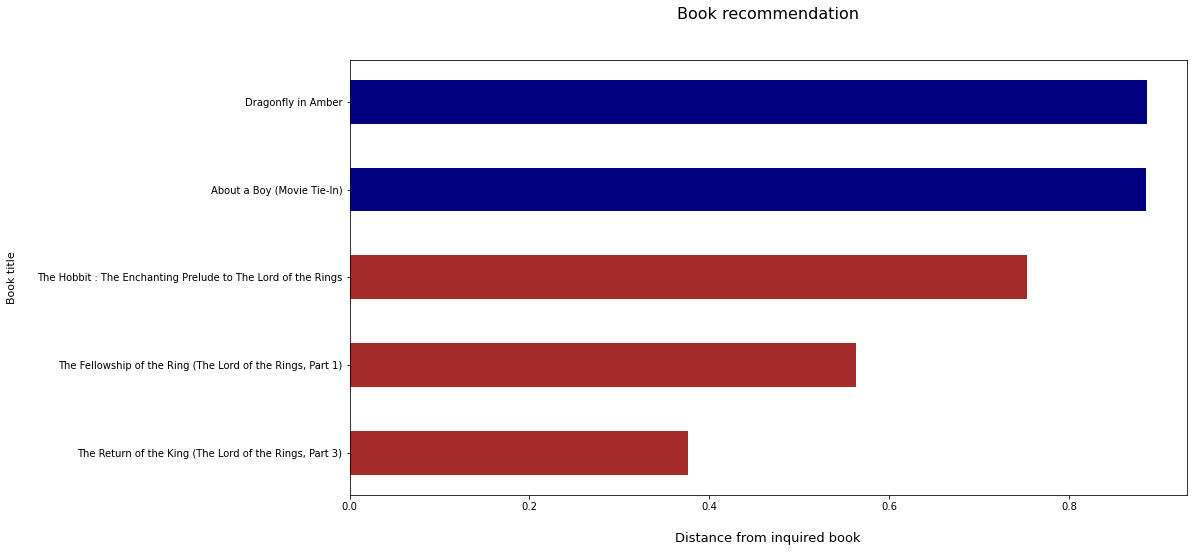

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.barh(lst_book, distances[0][1:], height = 0.5, color=['brown', 'brown', 'brown', '#000080', '#000080'])
plt.title('Book recommendation',  fontsize=16,  y=1.08)
plt.xlabel('Distance from inquired book', fontsize=13, labelpad=20)
plt.ylabel('Book title', fontsize=11, labelpad=20)

<b>The data visualization chart will be shown in the ppt using tableau.<b>

In [13]:
def get_df(lst_book, distances):
    distances = distances.reshape(-1)
    distances = distances[1:]
    d = {"Title": lst_book, "Distances from New Point": distances}
    df = pd.DataFrame(d)
    return df

df = get_df(lst_book, distances)
df.to_excel('distance.xlsx', index = False)

In [25]:
rings = rating_books_users.loc[rating_books_users['title'].str.contains('lord of the rings', case=False)]
rings.to_csv('ring.csv', index = False)


In [29]:
rings['age'] = rings['age'].astype(int)
rings.describe()

,user_id,rating,age
count,397.000000,397.000000,397.000000
mean,141697.687657,3.949622,33.317380
std,77369.243041,4.678284,11.449274
min,638.000000,0.000000,13.000000
25%,69721.000000,0.000000,26.000000
50%,138995.000000,0.000000,32.000000
75%,208406.000000,10.000000,39.000000
max,277427.000000,10.000000,116.000000


Text(0.5, 0, 'Age group')

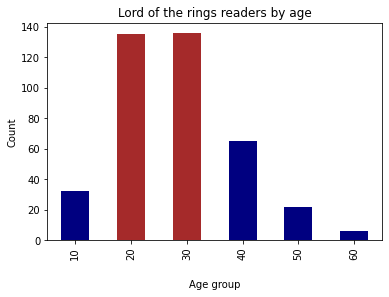

In [64]:
bins = [10, 19, 29, 39, 49, 59,69]
labels = [10,20,30,40,50,60]
rings['binned'] = pd.cut(rings['age'], bins = bins, labels=labels)
df_ring = rings.groupby(['binned']).size()
df_ring.plot(kind = 'bar', color=['#000080', 'brown', 'brown', '#000080', '#000080'])
plt.title('Lord of the rings readers by age')
plt.ylabel('Count')
plt.xlabel('Age group', labelpad=20)